In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# Set random seed for parallel computation

In [2]:
# 设置随机种子
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Set words divider and words maker function

In [3]:
# 定义分词器和词汇表构建函数
tokenizer = get_tokenizer('basic_english')
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)


In [4]:
# 加载数据集
train_iter, test_iter = IMDB(split=('train', 'test'))

# 构建词汇表
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# 文本和标签处理函数
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: 1 if x == 'pos' else 0

In [5]:
list(train_iter)[0]

(1,
 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far betwee

In [6]:
# 数据加载器
def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         lengths.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.float)
    text_list = nn.utils.rnn.pad_sequence(text_list, batch_first=True)
    lengths = torch.tensor(lengths, dtype=torch.int64)
    return label_list, text_list, lengths


In [7]:
# Custom dataset class
class CustomIMDBDataset(Dataset):
    def __init__(self, data_iter):
        self.data = list(data_iter)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label, text = self.data[idx]
        return label, text

In [8]:
# Create custom datasets
train_dataset = CustomIMDBDataset(train_iter)
test_dataset = CustomIMDBDataset(test_iter)
    
BATCH_SIZE = 64
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)


## Create RNN model

In [9]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), batch_first = True, enforce_sorted = False)
        packed_output, hidden = self.rnn(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first = True)
        hidden = self.dropout(hidden[-1, :, :])
        return self.fc(hidden)

# 创建模型实例

In [10]:
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

# 训练模型

In [11]:
model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

# 训练模型
optimizer = optim.SGD(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

In [13]:
def train(model, dataloader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for labels, texts, text_lengths in dataloader:
        labels, texts = labels.to(device), texts.to(device)
        optimizer.zero_grad()
        predictions = model(texts, text_lengths).squeeze(1)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

def accuracy(predictions, labels):
    # Round predictions to the closest integer (0 or 1)
    rounded_preds = torch.round(torch.sigmoid(predictions))
    correct = (rounded_preds == labels).float()
    acc = correct.sum() / len(correct)
    return acc

In [21]:
# 记录训练过程
num_epochs = 20
train_losses = []
train_acc_list = []

for epoch in range(num_epochs):
    train_loss = train(model, train_dataloader, optimizer, criterion)
    train_losses.append(train_loss)

    # Calculate accuracy on the training set
    model.eval()
    with torch.no_grad():
        correct_predictions = 0
        total_predictions = 0
        for labels, texts, text_lengths in train_dataloader:
            labels, texts = labels.to(device), texts.to(device)
            predictions = model(texts, text_lengths).squeeze(1)
            acc = accuracy(predictions, labels)
            correct_predictions += acc.item()
            total_predictions += 1
        train_accuracy = correct_predictions / total_predictions
        train_acc_list.append(train_accuracy)

    # Print training loss for the current epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f}')

Epoch [1/20] - Train Loss: 0.0013 - Train Accuracy: 1.0000
Epoch [2/20] - Train Loss: 0.0013 - Train Accuracy: 1.0000
Epoch [3/20] - Train Loss: 0.0012 - Train Accuracy: 1.0000
Epoch [4/20] - Train Loss: 0.0011 - Train Accuracy: 1.0000
Epoch [5/20] - Train Loss: 0.0010 - Train Accuracy: 1.0000
Epoch [6/20] - Train Loss: 0.0010 - Train Accuracy: 1.0000
Epoch [7/20] - Train Loss: 0.0009 - Train Accuracy: 1.0000
Epoch [8/20] - Train Loss: 0.0009 - Train Accuracy: 1.0000
Epoch [9/20] - Train Loss: 0.0008 - Train Accuracy: 1.0000
Epoch [10/20] - Train Loss: 0.0008 - Train Accuracy: 1.0000
Epoch [11/20] - Train Loss: 0.0008 - Train Accuracy: 1.0000
Epoch [12/20] - Train Loss: 0.0007 - Train Accuracy: 1.0000
Epoch [13/20] - Train Loss: 0.0007 - Train Accuracy: 1.0000
Epoch [14/20] - Train Loss: 0.0007 - Train Accuracy: 1.0000
Epoch [15/20] - Train Loss: 0.0006 - Train Accuracy: 1.0000
Epoch [16/20] - Train Loss: 0.0006 - Train Accuracy: 1.0000
Epoch [17/20] - Train Loss: 0.0006 - Train Accura

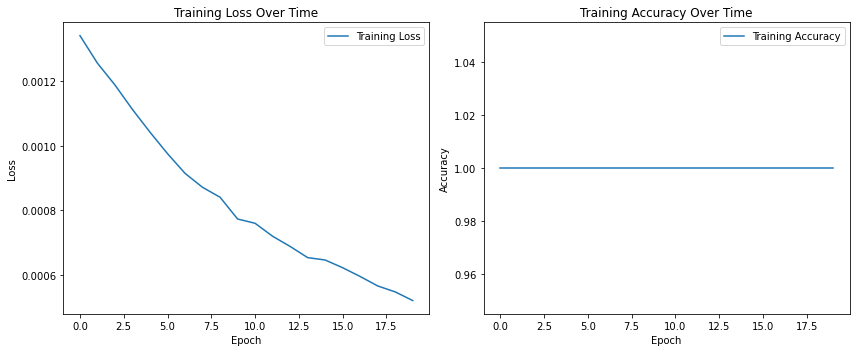

In [22]:
# Plot both training loss and accuracy over time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # Create a figure with two subplots (1 row, 2 columns)

# Plot training loss on the first subplot (ax1)
ax1.plot(train_losses, label='Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Over Time')
ax1.legend()

# Plot training accuracy on the second subplot (ax2)
ax2.plot(train_acc_list, label='Training Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training Accuracy Over Time')
ax2.legend()

plt.tight_layout()  # Adjust subplots for better layout